# Goals
    _x_ Install Tensorflow 
    _x_ Install pymongo
    _x_ Read from pymongo
    _x_ Figure out how to give image data to Sklearn models
        1. Multi Dimensional np.array
        2. Convert to PIL.Image to reshape all images to same size (Need to make them smaller)
        3. Convert back to np.array
        4. Let X = pd.DataFrame(np.row_stack(df.numpy_arr))
    ___ Rethink project
        1. Stick with Race ID
            ___ Scrape more images to train on
            ___ Keep or drop Native American
        2. Transition over to Ethinicity
        3. Transition from Race to something simpler i.e.
            a. Mask vs No Mask
                - https://www.youtube.com/results?search_query=object+detect+mask+vs+no+mask
            b. Cats vs Dogs
            c. Pedestrian vs Vehicle
                - Possibly exapand vehicle into Car, Bike, Scooter, Truck
    ___ Move into a cluster setting
    ___ Learn and Impliment TensorFlow
    ___ Future Direction
        1. The Frame work is pretty versatile so it would be cool to have realtime translations of sign language
        2. Make a UI for uploading and labeling images
            a. Similar to Amazon Turk
        3. Improve quality of training set
        4. Try different models
            a. CV grid for the Decision Tree
            b. SVM, CNN, etc.

# Installs

In [1]:
# import sys

# !pip install --prefix {sys.prefix} tensorflow

In [2]:
# import sys

# !pip install --prefix {sys.prefix} scikit-learn

In [3]:
# conda install scikit-image

# Imports

In [103]:
import pickle
from PIL import Image 
from skimage import io
import random
import pandas as pd
import pymongo
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import cross_val_score
from sklearn import tree
import numpy as np
import tensorflow as tf
# smart phrone: ssd_mobilenet
# laptop: rcnn

# Connect to MongoDB

In [3]:
user = ""
pswd = ""

client = pymongo.MongoClient("mongodb+srv://{}:{}@cluster0.ihx5p.mongodb.net/<dbname>?retryWrites=true&w=majority".format(user, pswd))
db = client["DATA_603"]
collection = db["test_images"]

# Test Connection

In [4]:
def check_db_collection(race="American Indian"):
    count = 0
    cursor = collection.find({"race": race})
    for document in cursor:
        # num = document["_id"]
        # print(num)
        # num = num.split("_")[-1]
        # print(num)
        # if int(num) % 10 == 0:
        print(document["_id"])
        img = pickle.loads( document["numpy_arr"] )
        Image.fromarray(img, 'RGB').show(title=document["_id"])
        count += 1 
#         if count == 10:
#             return 
    
# check_db_collection()

# Hold images in a container
Cast as Image to resize and grey, and then cast bast as numpy array to flatten array and split into feature columns

In [13]:
print(db["mask_images"].count_documents({}))
print(db["test_images"].count_documents({}))

100
568


In [19]:
%time df_mask = pd.DataFrame(db["mask_images"].find({}))

In [20]:
%time df_race = pd.DataFrame(db["test_images"].find({}))

CPU times: user 3.21 s, sys: 2.29 s, total: 5.5 s
Wall time: 45min 36s


In [192]:
df = df_mask.append(df_race, sort=False).reset_index()
df = df[["_id", "source_url", "numpy_arr", "target"]]
df["target"].fillna("No Mask", inplace=True)
df

,_id,source_url,numpy_arr,target
0,Covid_Mask_0,https://image.shutterstock.com/image-photo/sho...,b'\x80\x02cnumpy.core.multiarray\n_reconstruct...,Covid Mask
1,Covid_Mask_1,https://image.shutterstock.com/image-photo/cor...,b'\x80\x02cnumpy.core.multiarray\n_reconstruct...,Covid Mask
2,Covid_Mask_2,https://image.shutterstock.com/image-photo/clo...,b'\x80\x02cnumpy.core.multiarray\n_reconstruct...,Covid Mask
3,Covid_Mask_3,https://image.shutterstock.com/image-photo/clo...,b'\x80\x02cnumpy.core.multiarray\n_reconstruct...,Covid Mask
4,Covid_Mask_4,https://image.shutterstock.com/image-photo/gor...,b'\x80\x02cnumpy.core.multiarray\n_reconstruct...,Covid Mask
...,...,...,...,...
663,Native_Hawaiian_63,https://image.shutterstock.com/image-photo/por...,b'\x80\x02cnumpy.core.multiarray\n_reconstruct...,No Mask
664,Native_Hawaiian_64,https://image.shutterstock.com/image-photo/por...,b'\x80\x02cnumpy.core.multiarray\n_reconstruct...,No Mask
665,Native_Hawaiian_65,https://image.shutterstock.com/image-photo/haw...,b'\x80\x02cnumpy.core.multiarray\n_reconstruct...,No Mask
666,Native_Hawaiian_66,https://image.shutterstock.com/image-photo/por...,b'\x80\x02cnumpy.core.multiarray\n_reconstruct...,No Mask


In [193]:
df["numpy_arr"] = df["numpy_arr"].apply(lambda x: pickle.loads(x))
df["numpy_arr"] = df["numpy_arr"].apply(lambda x: Image.fromarray(x, 'RGB'))
# %time df

# Rerformat Images (Crop, grayscale, fixed size)
Ref: https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/

https://scikit-learn.org/0.15/auto_examples/cluster/plot_dict_face_patches.html

In [194]:
# Reduce data
# h = (8/10)*h_old = (4/5)*h_old
# w = (8/10)*w_old = (4/5)*h_old
# a = (16/25)*a_old = .64*a_old = (1 - .36)*a_old
def my_crop(x):
    reducing_term = 10
    left = 1*width / reducing_term
    top = 0#height / reducing_term
    right = width * ((reducing_term-1)/ reducing_term)
    bottom = height * ((reducing_term-2)/ reducing_term)

    # Cropped image of above dimension 
    # (It will not change orginal image) 
    return x.crop((left, top, right, bottom)) 

df["numpy_arr"] = df["numpy_arr"].apply(lambda x: my_crop(x))

In [195]:
temp = pd.DataFrame()

temp["H"] = df["numpy_arr"].apply(lambda x: x.size[0])
temp["W"] = df["numpy_arr"].apply(lambda x: x.size[1])

temp.describe()
size = round(temp["H"].mean()), temp["W"].mean()
size = int(size[0]), int(size[1])
size

(276, 224)

# Note, Incomming images will have to be reshaped to the same size

In [196]:
# Convert the image to grayscale
df["numpy_arr"] = df["numpy_arr"].apply(lambda x: x.convert(mode='L'))
# Resize Image
df["numpy_arr"] = df["numpy_arr"].apply(lambda x: x.resize(size))
# df["numpy_arr"] = df["numpy_arr"].apply(lambda x: x.resize((64,64))) # Currently looses too much information

# Flatten numpy arr and transform into columns

In [197]:
# df # Should be PIL Image Objects

In [198]:
# Flatten Numpy Arr - cant convert into PIL Image
df["numpy_arr"] = df["numpy_arr"].apply(lambda x: np.array(x))

df["numpy_arr"] = df["numpy_arr"].apply(lambda x: x.flatten("F"))
# temp = df["numpy_arr"][0].reshape((334,280)).T # To undo 

# df["numpy_arr"] = df["numpy_arr"].apply(lambda x: x.flatten())
# temp = df["numpy_arr"][0].reshape((280,334)) # To undo
# Image.fromarray(temp)

In [199]:
# df

# Model doesn't do too bad on a binary classification

In [200]:
temp = df.copy()
# temp = temp[(temp["race"]=="African American") | (temp["race"]=="Native Hawaiian")]

X = pd.DataFrame(np.row_stack(temp.numpy_arr))
Y = np.array(temp.target)

X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    random_state=2020)

In [201]:
# # random.choice(X)
# display(X)
# #%time display(pd.DataFrame(list(map(np.ravel, X))))
# %time display(pd.DataFrame(np.row_stack(X))) # WINNER !!!
# %time display(pd.DataFrame(X))

# Using sklearn 

In [202]:
model = tree.DecisionTreeClassifier(random_state=2020)
%time model = model.fit(X_train, Y_train)

CPU times: user 25.7 s, sys: 193 ms, total: 25.9 s
Wall time: 27.5 s


# TBD
This implies that the model is over fitting to the training data (All races)

In [203]:
print("Training data:", model.score(X_train, Y_train))
print("Testing data: ", model.score(X_test, Y_test))

Training data: 1.0
Testing data:  0.7761194029850746


# Using TensorFlow Deep Learning

In [204]:
size

(276, 224)

In [205]:
# # Initialize Model
# model_tf = tf.keras.Sequential([
#     # Number of pixels per image, flattened
#     #tf.keras.layers.Flatten(input_shape=size),
#     # Number of nodes in first layer
#     tf.keras.layers.Dense(128, activation='relu'),
#     # Number of outputs (Mask vs No Mask)
#     tf.keras.layers.Dense(2)
# ])

# # Compile Model
# model_tf.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# # Train Model
# model_tf.fit(X_train, Y_train, epochs=10)

# Resizing Options
https://www.geeksforgeeks.org/python-pil-image-crop-method/

Initial (276, 224)
Final (166, 179)


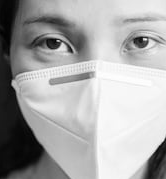

In [206]:
temp = df["numpy_arr"][7].reshape(size).T # To undo 
# temp = df["numpy_arr"][0].reshape((280,334)) # To undo 
im = Image.fromarray(temp)

# Size of the image in pixels (size of orginal image) 
# (This is not mandatory) 
print("Initial", im.size)
width, height = im.size 
  
# Setting the points for cropped image 
reducing_term = 10
left = 2*width / reducing_term
top = 0#height / reducing_term
right = width * ((reducing_term-2)/ reducing_term)
bottom = height * ((reducing_term-2)/ reducing_term)
  
# Cropped image of above dimension 
# (It will not change orginal image) 
im1 = im.crop((left, top, right, bottom)) 
  
# Shows the image in image viewer 
# im1.show() 
print("Final", im1.size)
im1

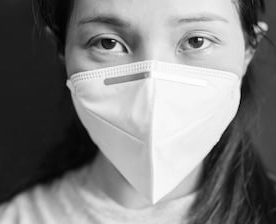

In [207]:
# size = 64, 64
im2 = im.resize((size))
im2